In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from skimpy import clean_columns
from wordcloud import WordCloud
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import SMOTE

In [12]:
df_listing = pd.read_csv('Listings.csv', low_memory=False)
print("Total row and column in the dataset:", df_listing.shape)

Total row and column in the dataset: (41533, 75)


**DATA CLEANING**

In [13]:
#Drop unecessary columns
df_listing.drop(columns = ['source','description','listing_url','host_thumbnail_url','picture_url','host_url','host_thumbnail_url','host_picture_url',
                           'last_scraped','scrape_id','license','calendar_updated', 'host_has_profile_pic','host_name',
                           'host_since','host_identity_verified','host_acceptance_rate','bathrooms_text','first_review','host_about',
                           'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights',
                           'minimum_nights_avg_ntm','maximum_nights_avg_ntm','neighbourhood','neighbourhood_cleansed','host_response_time',
                           'host_listings_count','host_total_listings_count','host_verifications','calendar_last_scraped','number_of_reviews_ltm',
                           'number_of_reviews_l30d','host_id','last_review','calculated_host_listings_count',
                           'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms'
                              ], axis=1, inplace=True)

In [14]:
#Replace missing values in the dataset
df_listing.fillna({'bathrooms':1, 'bedrooms':1, 'beds':1}, inplace=True)
df_listing.fillna({'last_review':0, 'review_scores_rating':0, 'review_scores_accuracy':0, 'review_scores_cleanliness':0, 
        'review_scores_checkin':0, 'review_scores_communication':0, 'review_scores_location':0,
        'review_scores_value':0,'reviews_per_month':0,'neighborhood_overview':'NA','description':'NA',
        'host_is_superhost':'f','name':'NA','host_location':'New York, NY','host_response_rate':'N/A',
        'host_neighbourhood':'NA','host_listings_count':0}, inplace=True)

In [15]:
#Check the missing values in the dataframe
missing_values = df_listing.columns[df_listing.isna().sum() > 0]

if missing_values.empty:
    print("No missing values")
else:
    missing_data = df_listing.loc[:, missing_values]
    print("Missing values\n", missing_data.isna().sum())

No missing values


In [16]:
#Check the datatype of variables
df_listing.dtypes

id                              float64
name                             object
neighborhood_overview            object
host_location                    object
host_response_rate               object
host_is_superhost                object
host_neighbourhood               object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
amenities                        object
price                            object
minimum_nights                    int64
maximum_nights                    int64
has_availability                 object
availability_30                   int64
availability_60                   int64
availability_90                   int64
availability_365                  int64


In [17]:
#Converting t and f to 1 and 0
df_listing['host_is_superhost'] = df_listing['host_is_superhost'].apply(lambda x: 1 if x == "t" else 0)
df_listing['instant_bookable'] = df_listing['instant_bookable'].apply(lambda x: 1 if x == "t" else 0)
df_listing['has_availability'] = df_listing['has_availability'].apply(lambda x: 1 if x == "t" else 0)

In [18]:
# df_listing.to_csv('modified.csv', index=False)
# df_listing = pd.read_csv('modified.csv', low_memory=True)

**DATA EXPLORATION & ANALYSIS:**
1. The average price per night of an AirBnb listing in NYC. How does the average price of an AirBnb listing per month compare to the private rental market?
2. Room types vs price
3. Boroughs vs price
4. Amenities and price


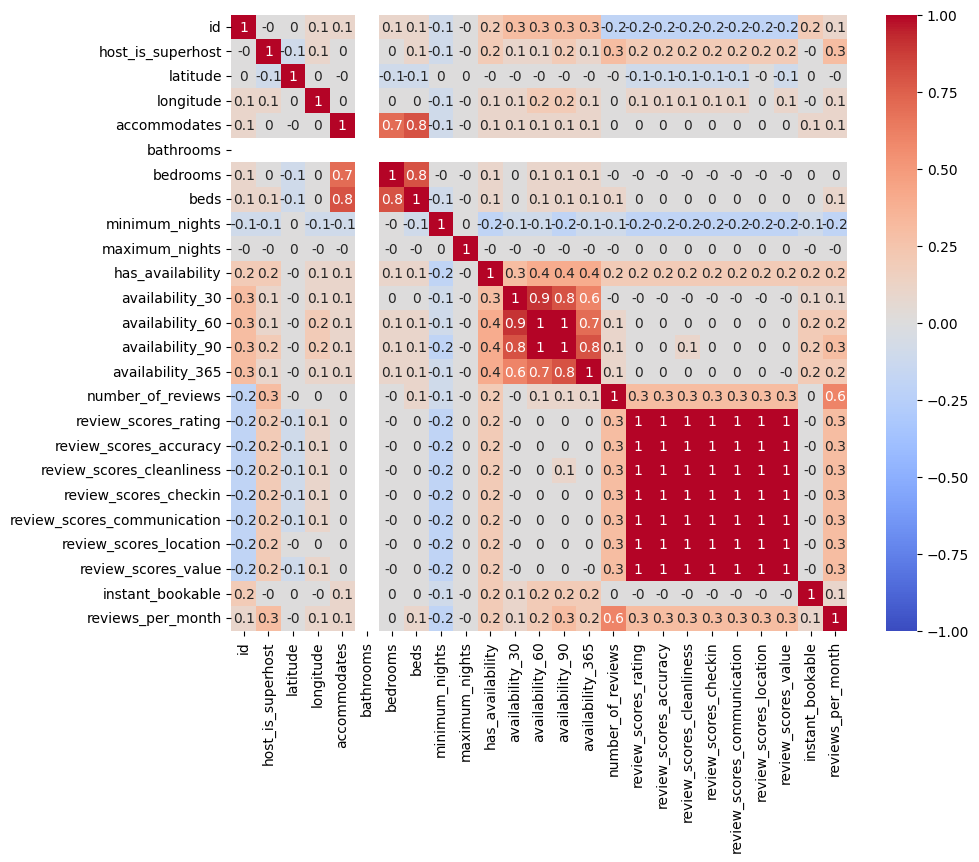

In [19]:
# create correlation matrix
corr_matrix = df_listing.corr().round(1)
# plot the matrix
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, square=True)
plt.show()

**1. Average price**

In [20]:
#Change type of price to float
df_listing["price"] = df_listing["price"].map(lambda x: float(x.replace("$", "").replace(",", "")))
# df_listing["price"] = df_listing["price"].str.replace('.00','')
# df_listing["price"] = df_listing["price"]
df_listing["price"]

0         175.0
1          75.0
2         275.0
3          60.0
4          68.0
          ...  
41528     105.0
41529      87.0
41530      70.0
41531     125.0
41532    1114.0
Name: price, Length: 41533, dtype: float64

In [21]:
#Find average price per night of AirBnb in NY
avg_price_per_night = df_listing["price"].mean()

#Find average price per month of Airbnb in NY
avg_monthly_price = round(avg_price_per_night*365/12, 2)

#Conclude the comparision between monthly price of AirBnb and that of private market in NY
print("While average monthly AirBnb price is: ${}, the price of private market according to Zumper is {}".format(avg_monthly_price, "$3100") )

While average monthly AirBnb price is: $6751.84, the price of private market according to Zumper is $3100


**2. Room types vs price**

In [22]:
#Lowercase room column
df_listing['room_type'].map(lambda x: x.lower())

#Count the frequency of room types
num_room_types = df_listing['room_type'].value_counts()
num_room_types

Entire home/apt    23526
Private room       17287
Shared room          532
Hotel room           188
Name: room_type, dtype: int64

In [23]:
#Average price of each room types
total_price_of_each_room_type = df_listing.groupby(['room_type']).sum()['price']

price_of_each_room_type = total_price_of_each_room_type/num_room_types

price_of_each_room_type

Entire home/apt    263.442404
Hotel room         416.164894
Private room       166.102042
Shared room        135.400376
dtype: float64

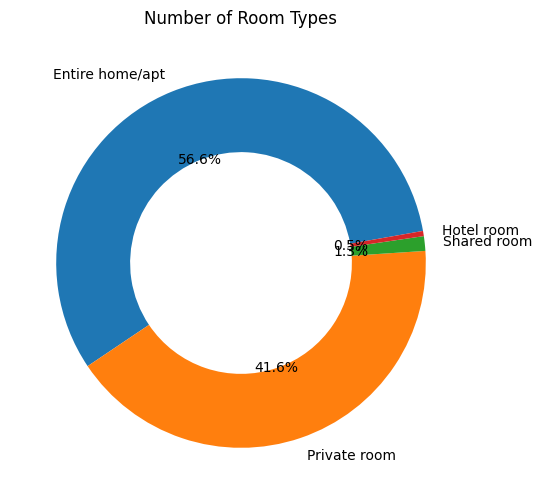

In [24]:
# Plot the pie chart
fig, ax = plt.subplots(figsize=(6,6))
ax.pie(num_room_types, labels=num_room_types.index, startangle=10, autopct='%1.1f%%', wedgeprops={'width':0.4})
ax.set_aspect('equal')
ax.set_title('Number of Room Types')
plt.show()

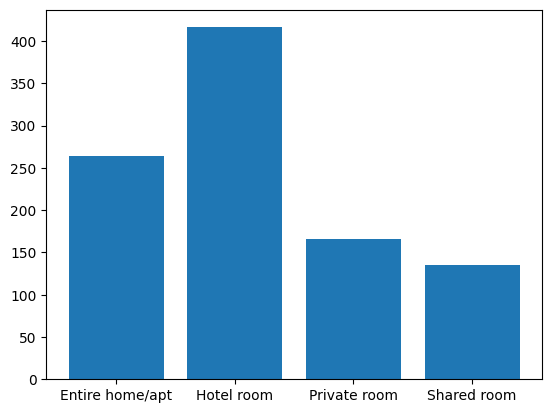

In [25]:
#barplot shows comparision between number of room and average price per night of each type
room_types = ['Entire home/apt', 'Hotel room', 'Private room', 'Shared room']
plt.bar(room_types, price_of_each_room_type)
plt.show()

**3. Boroughs vs price**

In [26]:
df_listing['neighbourhood_group_cleansed']

0        Manhattan
1        Manhattan
2         Brooklyn
3         Brooklyn
4         Brooklyn
           ...    
41528        Bronx
41529       Queens
41530    Manhattan
41531        Bronx
41532    Manhattan
Name: neighbourhood_group_cleansed, Length: 41533, dtype: object

Find the most popular neighborhoods for AirBnb rentals in NYC and show how price vary between these neighborhoods

In [27]:
boroughs = df_listing.groupby('neighbourhood_group_cleansed').agg({'price':['max','min', 'mean', 'median', 'count']})
boroughs

price                                
                                  max   min        mean median  count
neighbourhood_group_cleansed                                         
Bronx                         95110.0   0.0  180.816635   89.0   1587
Brooklyn                      98159.0   0.0  171.926441  119.0  15688
Manhattan                     19750.0   0.0  301.211665  175.0  17334
Queens                        10000.0  10.0  135.656389   93.0   6519
Staten Island                 65115.0  30.0  320.343210  100.0    405

Now, we assume that there are five range of price to categorize the AirBnb in New York, including:
1. Budget: $0 - 100
2. Average: $101 - 200
3. Expensive: $201 - 400
4. Luxury: > $401 - 1000
5. Presidential: > $1000

Now, we analyze number of AirBnb in different boroughs

In [28]:
#Create list of rank for AirBnb room
rank_room = ["Budget", "Average", "Expensive", "Luxury", "Presidential"]

#Create the range
ranges = [0, 100, 200, 400, 1000, np.inf]

#Input new column for price_range
df_listing["ranges"] = pd.cut(df_listing["price"], bins=ranges, labels=rank_room)

#Categorize room in different price ranges in boroughs of NY
room_by_price_range = df_listing.groupby(["ranges", "neighbourhood_group_cleansed"])["price"].count()
print(room_by_price_range)

ranges        neighbourhood_group_cleansed
Budget        Bronx                            951
              Brooklyn                        6915
              Manhattan                       3868
              Queens                          3696
              Staten Island                    208
Average       Bronx                            481
              Brooklyn                        5487
              Manhattan                       6311
              Queens                          1933
              Staten Island                    141
Expensive     Bronx                            136
              Brooklyn                        2599
              Manhattan                       4525
              Queens                           722
              Staten Island                     39
Luxury        Bronx                             14
              Brooklyn                         588
              Manhattan                       1952
              Queens                   

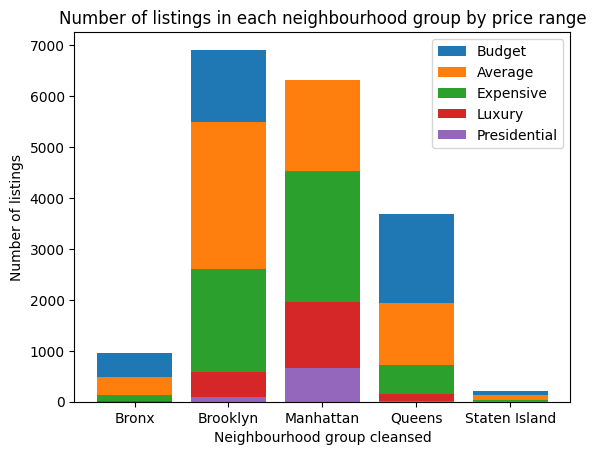

In [29]:
#Create plot for AirBnb room ranks

room_by_price_range = room_by_price_range.reset_index()
price_ranges = room_by_price_range['ranges'].unique()

fig, ax = plt.subplots()
for price_range in price_ranges:
    filtered_df = room_by_price_range[room_by_price_range['ranges'] == price_range]
    ax.bar(filtered_df['neighbourhood_group_cleansed'], filtered_df['price'], label=price_range)

ax.set_xlabel('Neighbourhood group cleansed')
ax.set_ylabel('Number of listings')
ax.legend()
ax.set_title('Number of listings in each neighbourhood group by price range')
plt.show()

**4. Amenities vs price**

In [30]:
#clean the amenities column
df_listing["amenities"] = df_listing["amenities"].str.replace("\\", "")

c:\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


Most common amenities and features and their impacts on the price

In [31]:
#Count the frequencies of amenities
from collections import Counter
count_amen = Counter()
for row in df_listing['amenities']:
    count_amen.update(row[1:-1].replace("\"", "").split(", "))


In [32]:
#Find top 10 most common amenities
top10_amenities = [a for a, c in list(count_amen.items())[:10]]

In [33]:
#Find the mean price of houses which have one of top 10 most common amenities
amen_vs_mean_price = []
for amen in top10_amenities:
    amen_vs_mean_price.append((
        amen, 
        df_listing.query("amenities.str.contains(@amen)")["price"].mean(skipna=True)
    ))

sorted_amen_vs_mean_price = sorted(amen_vs_mean_price, key=lambda x: x[1], reverse=True)
sorted_amen_vs_mean_price

[('Self check-in', 264.29237288135596),
 ('Bed linens', 253.72628943415123),
 ('TV', 250.36045083902653),
 ('Bathtub', 248.16582484376337),
 ('Iron', 247.02498462484624),
 ('Carbon monoxide alarm', 234.72527300112966),
 ('Long term stays allowed', 217.65894075021313),
 ('Essentials', 211.40771694816542),
 ('Kitchen', 201.32095844212358),
 ('Stove', 200.55078705078705)]

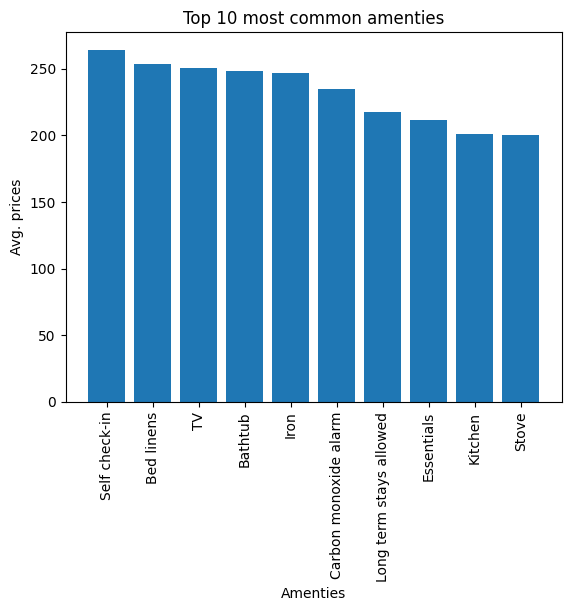

In [34]:
# plot for average price of houses which have one of top 10 most common amenities
labels, values = zip(*sorted_amen_vs_mean_price)

plt.bar(labels, values)
plt.xlabel('Amenties')
plt.ylabel('Avg. prices')
plt.title('Top 10 most common amenties')
plt.xticks(rotation=90)

plt.show()

**MODELING**

In this step, we prepare machine learning data models such as:
1. Normalize numeric features
2. Convert the categorical variables into numeric features
3. Split the data into a training set and a test set
4. Create models such as Linear Regression, Random Forest and Gradient Boosting
5. Evaluate the models performance and benchmark model accuracy

In [35]:
# Check the datatype of target variable
df_listing.price.dtypes

dtype('float64')

In [36]:
# List of numerical variables
numerical_vars = ['id', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 
                  'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
                  'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                  'review_scores_communication', 'review_scores_location','price', 'review_scores_value', 'reviews_per_month',
                  'has_availability','instant_bookable','host_is_superhost']


In [37]:
# List of categorical variables
categorical_vars = ['name', 'host_neighbourhood','neighbourhood_group_cleansed', 'host_location', 'host_response_rate', 
                    'host_neighbourhood', 'property_type', 'room_type']

In [38]:
# Drop zero variable numerical variables
zero_variance_numerical_variables = [col for col in df_listing.columns if (df_listing[col].dtype in ['int64', 'float64'] and df_listing[col].std() == 0)]

df_listing = df_listing.drop(zero_variance_numerical_variables, axis=1)

In [39]:
# Drop zero variable categorical variables
zero_variance_categorical_variables = []
categorical_vars = list(df_listing.dtypes[df_listing.dtypes == object].index)

for i in categorical_vars:
    if len(df_listing[i].value_counts().index) == 1:
        zero_variance_categorical_variables.appen(i)
    
df_listing = df_listing.drop(zero_variance_categorical_variables, axis=1)

**Model Fitting & Evaluation**
- Prepare machine learning data models such as 
- Normalize numeric features
- Convert the categorical variables into numeric features
- Split the data into a training set and a test set.
- Create models such as (Linear Regression, Random Forest and Gradient Boosting )
- Evaluate the models’ performance and benchmark model accuracy.

In [40]:
# check target variable datatype
df_listing.price.dtypes

dtype('float64')

**1. Data preprocessing**

In [41]:
#create list for numerical and categorical variable
numerical_vars = ['id', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 
                  'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews',
                  'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                  'review_scores_communication', 'review_scores_location','price', 'review_scores_value', 'reviews_per_month',
                  'has_availability','instant_bookable','host_is_superhost']

categorical_vars = ['name', 'host_neighbourhood','neighbourhood_group_cleansed', 'host_location', 'host_response_rate', 
                    'host_neighbourhood', 'property_type', 'room_type']

In [42]:
# drop zero variable numerical variables
zero_variance_numerical_variables = [col for col in df_listing.columns if (df_listing[col].dtype in ['int64', 'float64'] and df_listing[col].std() == 0)]

df_listing = df_listing.drop(zero_variance_numerical_variables, axis=1)

In [43]:
# drop zero variable categorical variables
zero_variance_categorical_variables = []

categorical_vars = list(df_listing.dtypes[df_listing.dtypes == object].index)

for i in categorical_vars: 
    if len(df_listing[i].value_counts().index) ==1 :
           zero_variance_categorical_variables.append(i)
                   
df_listing = df_listing.drop(zero_variance_categorical_variables, axis=1)

In [44]:
# drop high cardinality variables with high variance > 200 categorical variables 
high_cardinality_categorical_variables = [] 

categorical_vars = list(df_listing.dtypes[df_listing.dtypes == object].index)

for i in categorical_vars: 
    if len(df_listing[i].value_counts().index) >200 :
           high_cardinality_categorical_variables.append(i)

df_listing = df_listing.drop(high_cardinality_categorical_variables, axis=1)

In [45]:
# standardize and scaling standardize numerical variables
df_listing = df_listing.drop(df_listing.std()[df_listing.std() ==0].index, axis=1)

# extract numerical val
numeric_var = list(set(df_listing.columns) - set(df_listing.dtypes[df_listing.dtypes == object].index))

# create col name for standardize val
new_col = [i for i in numeric_var]

df_listing[numeric_var] = df_listing[numeric_var].apply(pd.to_numeric, errors='coerce')

# convert nurmic_var to numpy array
array = df_listing[numeric_var].values


data_scaler = StandardScaler().fit(array)

df_listing[new_col] = pd.DataFrame(data_scaler.transform(array))

c:\Python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
c:\Python37\lib\site-packages\sklearn\utils\extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Python37\lib\site-packages\sklearn\utils\extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
c:\Python37\lib\site-packages\sklearn\utils\extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


In [46]:
# encode categorical input variables
categorical_var = list( set(df_listing.dtypes[df_listing.dtypes ==object].index) - set(['price']) )

pd.get_dummies(df_listing[categorical_var], drop_first=True )

dummy_cat_df =pd.get_dummies(df_listing[categorical_var], drop_first=True )

df_listing = df_listing.drop(categorical_var, axis =1)

df_listing = pd.concat([df_listing, dummy_cat_df], axis=1)

df_listing.head()

,id,host_is_superhost,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,...,host_response_rate_91%,host_response_rate_92%,host_response_rate_93%,host_response_rate_94%,host_response_rate_95%,host_response_rate_96%,host_response_rate_97%,host_response_rate_98%,host_response_rate_99%,host_response_rate_N/A
0,-0.581077,-0.521078,0.442181,-0.733761,-0.942108,-0.469629,-0.551786,-0.051092,0.371595,-0.004946,...,0,0,0,0,0,0,0,0,0,0
1,-0.581077,-0.521078,1.321352,-0.410696,-0.942108,-0.469629,-0.551786,-0.159847,-0.540471,-0.005051,...,0,0,0,0,0,0,0,0,0,1
2,-0.581077,-0.521078,-1.148690,-0.893684,0.501236,0.893124,0.320590,0.057664,0.078431,-0.004946,...,0,0,0,0,0,0,0,0,0,1
3,-0.581077,1.919099,-0.751453,-0.189304,-0.460994,-0.469629,-0.551786,-0.176161,0.371595,-0.004983,...,0,0,0,0,0,0,0,0,0,0
4,-0.581077,-0.521078,-0.331467,-0.158928,0.020121,-0.469629,-0.551786,-0.167460,0.371595,-0.004983,...,0,0,0,0,0,0,0,0,0,0


In [47]:
print('No of encoded columns: ',len(df_listing.columns))

No of encoded columns:  179


In [48]:
df_listing['price'] = df_listing['price'].apply(lambda x: 1 if x > 0.5 else 0)
df_listing.price[:5]

0    0
1    0
2    0
3    0
4    0
Name: price, dtype: int64

In [49]:
# final check before resmaple
df_listing = df_listing.fillna(value=0)
if df_listing.isnull().sum().sum() > 0:
    print("Data contains missing values.")
else:
    print("Data does not contain any missing values.")

Data does not contain any missing values.


In [50]:
# Imbalanced variables to balanced it, using SMOTE resmaple function 
sm = SMOTE(random_state=0)
input_var = list( set(df_listing.columns) - set(['price']) )

X, Y = sm.fit_resample(df_listing[df_listing.columns.difference(['price'])], df_listing['price'] )
X = pd.DataFrame(X, columns = input_var)
y = pd.DataFrame(Y, columns = ['price'])

df_listing = pd.concat([X, Y], axis=1)

In [51]:
#validate balance data
df_listing['price'].value_counts()

0    39903
1    39903
Name: price, dtype: int64

**2. Split data into train and validation set**

In [52]:
# split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('70% Traing dataset: ',X_train.shape[0])
print('30% Test dataset:',X_test.shape[0])

70% Traing dataset:  55864
30% Test dataset: 23942


**3. Create Prediction Models**

- Linear Regression, In our case of price prediction for an Airbnb listing, a linear regression model might be trained on a dataset that includes information about various properties of the listing (e.g., roomtype, bedrooms, bathroom, location, etc.The model would then use this training data to learn the relationship between the predictor variables and the target variable (price) and make predictions about the price of new, unseen listings.

- Random Forest A random forest model would be trained on a dataset that includes information about various properties of the listing. A model works by creating many decision trees and then combining their predictions. Each decision tree is created using a random subset of the data and a random subset of the features. This helps to reduce the correlation between the trees, which in turn helps to reduce overfitting. The final prediction is made by averaging the predictions of all the decision trees in the forest. This approach often leads to a more robust and accurate model than a single decision tree.

- Gradient Boosting The model works by iteratively adding decision trees to the model, where each tree is designed to correct the mistakes of the previous trees. it is able to handle high dimensional data and also can handle missing values and outliers. It also provides feature importance, which can be used to select the most important features for modeling. It is also able to handle different types of data, such as categorical and numerical.

In [53]:
import random
# Create an XGBoost model
random.seed(42)
xgb_model = xgb.XGBRegressor()

# Train the model on the training data
xgb_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test).round()

In [54]:
# Create an LinearRegression model
random.seed(42)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test data
y_pred_lr = lr_model.predict(X_test).round()

In [55]:
# Create a random forest model
random.seed(42)
rf_model = RandomForestRegressor(n_estimators=100)

# Train the model on the training data
rf_model.fit(X_train, y_train.values.ravel())

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test).round()

**Feature importances indication**

In [56]:
# get the feature importances
importance = rf_model.feature_importances_
cols =[]
scores =[]
# extract importances/significant feature score
for i,v in enumerate(importance):
    if v >= 0.01:
        #print('Feature: %0d, Score: %.3f' % (i,v))
        cols.append(i)
        scores.append(v)

In [57]:
# extract importances/significant feature score
feature_name =[]
for i, v in enumerate(input_var):
    #print(i,v)
    if i in cols:
        #print(i, v)
        feature_name.append(v)

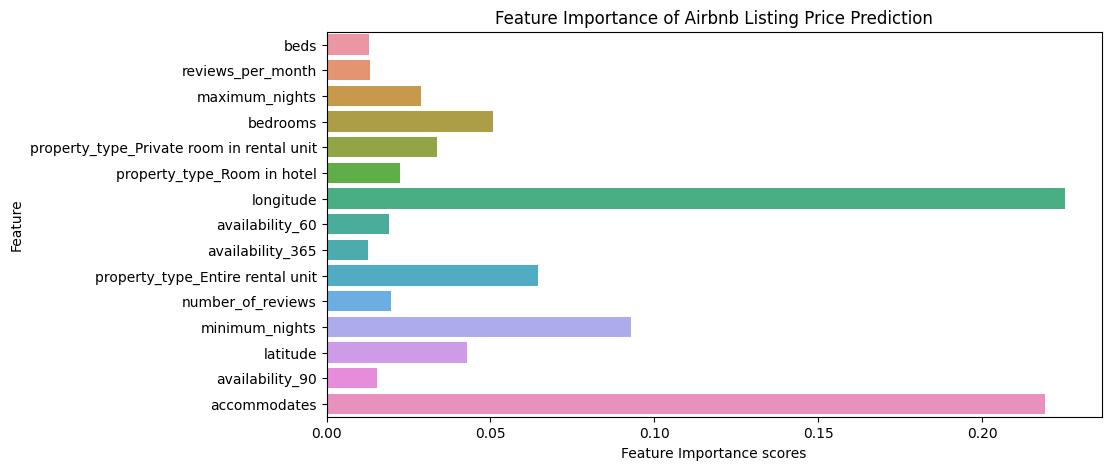

In [58]:
# create a bar plot
plt.figure(figsize=(10,5))
sns.barplot(x=scores, y=feature_name)
plt.xlabel('Feature Importance scores')
plt.ylabel('Feature')
plt.title('Feature Importance of Airbnb Listing Price Prediction')
plt.show()

**Reasons why they are impacting the Airbnb listing price prediction:**

minimum_nights: Minimum nights required to book a stay at a listing may impact the price, as longer stays may be priced differently than shorter stays.

availability_30: Number of days the listing is available in the next 30 days may impact the price, as listings with more availability may be priced differently than those with less availability.

number_of_reviews: Number of reviews a listing has may impact the price, as listings with more reviews may be priced differently than those with fewer reviews.

accommodates: Number of guests a listing can accommodate may impact the price, as listings that can accommodate more guests may be priced differently than those that can accommodate fewer guests.

host_response_rate_99%: The host response rate may impact the price, as listings with higher host response rates may be priced differently than those with lower host response rates.

longitude and latitude: The location of the listing may impact the price, as listings in certain areas may be priced differently than those in other areas.

property_type_Room in hotel and property_type_Private room in rental unit: The type of property may impact the price, as different types of properties may be priced differently.

room_type_Private room: The type of room may impact the price, as different types of rooms may be priced differently.

bedrooms: Number of bedrooms may impact the price, as listings with more bedrooms may be priced differently than those with fewer bedrooms.

host_response_rate_N/A: The host response rate may impact the price, as listings with higher host response rates may be priced differently than those with lower host response rates or no host response rate.

maximum_nights: Maximum nights allowed to book a stay at a listing may impact the price, as longer stays may be priced differently than shorter stays.

**4. K-mean Clustering for listing features**

In [59]:
from sklearn.cluster import KMeans
from scipy.spatial import distance

# Extract the features use for clustering
X_cluster = X_train[feature_name]

# Create an instance of the KMeans model
kmeans = KMeans(n_clusters=2)

# Fit the model to your data
kmeans.fit(X_cluster)

# Predict the cluster labels for each data point
labels = kmeans.predict(X_train[feature_name])

In [60]:
# Add the '2-means' cluster column to the data frame
X_train.loc[:, '2-means'] = labels + 1
mean_values = X_train.groupby('2-means')[feature_name].mean().T
print(mean_values)

2-means                                           1         2
beds                                      -0.129559  2.701904
reviews_per_month                         -0.054855 -0.133329
maximum_nights                            -0.005001 -0.005006
bedrooms                                  -0.133051  2.750401
property_type_Private room in rental unit  0.194099  0.003411
property_type_Room in hotel                0.123872  0.214555
longitude                                 -0.246602 -0.429309
availability_60                            0.124484  0.403728
availability_365                           0.116410  0.559543
property_type_Entire rental unit           0.324935  0.193376
number_of_reviews                         -0.075155 -0.213995
minimum_nights                            -0.081860 -0.333411
latitude                                   0.100989  0.057882
availability_90                            0.111295  0.423351
accommodates                              -0.057907  3.283029


In [61]:
# Calculate the Euclidean distance between the two clusters
euclidean_distance = distance.euclidean(mean_values[1], mean_values[2])

print("Euclidean distance between the two clusters:", round(euclidean_distance,2))

Euclidean distance between the two clusters: 5.3


**MODEL EVALUATION**

**1. Confusion Matrix for model performance indicator**

In [62]:
# compute confusion matrix and model performance indicator
def get_performance(actual_Y, pred_Y):
    cm = confusion_matrix(actual_Y, pred_Y)
    total = sum(sum(cm))
    accuracy = (cm[0,0] + cm[1,1] )/ total
    sensitivity = cm[0,0] / ( cm[0,0] + cm[0,1] )
    specificity = cm[1,1]/( cm[1,0] + cm[1,1] )
    return accuracy, sensitivity, specificity

In [63]:
acc_xgb, sens_xgb, spec_xgb = get_performance(y_test, y_pred_xgb)

threshold = 0.5
y_pred_lr_binary = np.where(y_pred_lr > threshold, 1, 0)

acc_lr, sens_lr, spec_lr = get_performance(y_test,  y_pred_lr_binary)

acc_rf, sens_rf, spec_rf = get_performance(y_test, y_pred_rf)

**2. Model Evaluation (Accuracy, Sensitivity, Specificity)**

In [64]:
# models performance evaluation
perf_tbl = pd.DataFrame([acc_xgb ,acc_lr, acc_rf], columns = ['Accuracy'], 
                               index=['Gradient Boosting','Linear Regression','Random Forest'])

perf_tbl['Sensitivity'] = np.asarray([sens_xgb, sens_lr, sens_rf])
perf_tbl['Specificity'] = np.asarray([spec_xgb, spec_lr, spec_rf])

perf_tbl.head(5)

,Accuracy,Sensitivity,Specificity
Gradient Boosting,0.977905,0.982251,0.973578
Linear Regression,0.918303,0.958862,0.877156
Random Forest,0.985757,0.983661,0.987884


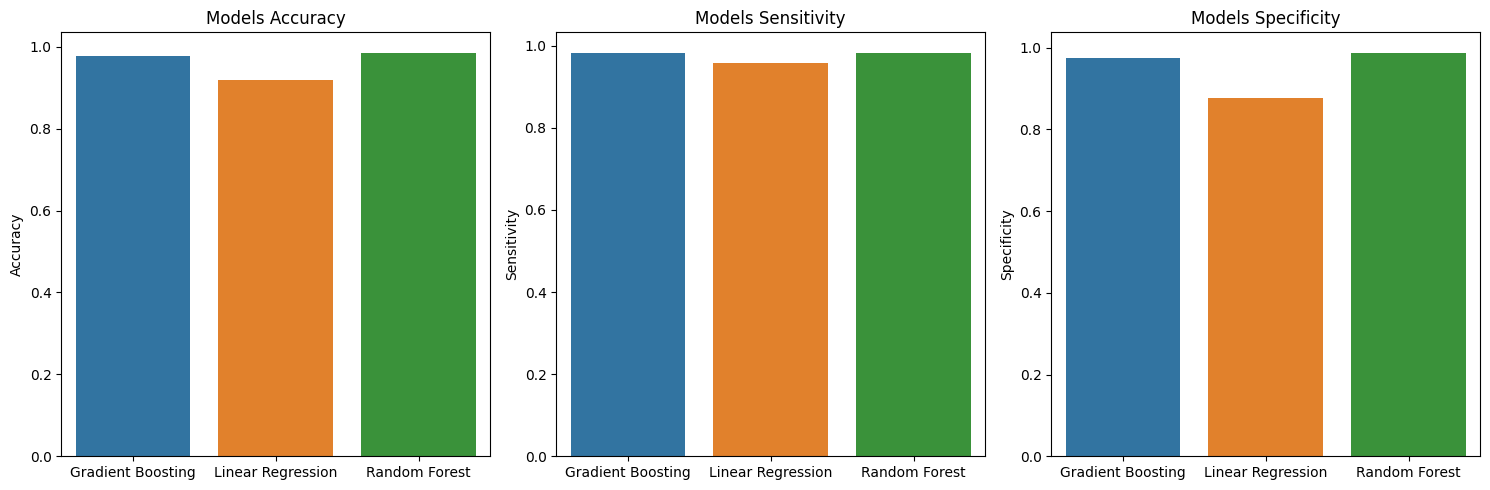

In [65]:
# create plot for performance evaluation
fig, axs = plt.subplots(1, 3, figsize=(15,5))

sns.barplot(x=perf_tbl.index, y='Accuracy', data=perf_tbl, ax=axs[0])
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Models Accuracy')

sns.barplot(x=perf_tbl.index, y='Sensitivity', data=perf_tbl, ax=axs[1])
axs[1].set_ylabel('Sensitivity')
axs[1].set_title('Models Sensitivity')

sns.barplot(x=perf_tbl.index, y='Specificity', data=perf_tbl, ax=axs[2])
axs[2].set_ylabel('Specificity')
axs[2].set_title('Models Specificity')

plt.tight_layout()
plt.show()

**3. All three model's accuracy, sensitivity and specificity**

accuracy: a measure of how many predictions the model got correct. It's the ratio of correct predictions to total predictions.

sensitivity: a measure of the proportion of true positive predictions (i.e., the number of correct positive (TP) predictions) out of all the actual positive cases.

specificity: a measure of the proportion of true negative predictions (i.e., the number of correct negative predictions (FP) ) out of all the actual negative cases.

Model summary
The Gradient Boosting model has the highest accuracy, sensitivity, and specificity. It means that the model is able to correctly predict the price of most of the listings in the dataset and it doesn't have a high rate of false positives or false negatives.

Random Forest also has a high accuracy but it has slightly less specificity than Gradient Boosting.

Linear Regression model has the lowest accuracy, sensitivity, and specificity among the three. It means that the model is not able to correctly predict the price of most of the listings in the dataset and it has a high rate of false positives or false negatives.

In our case, Gradient Boosting model might be the best option as it has the highest accuracy, sensitivity, and specificity. However, this conclusion is based on the our features metric values.